In [1]:
import os
import zipfile

import IPython.display as display
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten

# Load and process data

In [2]:
def columns_to_y(row):
  labels = ["Marker1", "Marker2", "Marker3", "Marker4",
            "ColorLeft", "ColorRight", "GrayScaleRight", "GreyScaleLeft"]#,
            #"CircleTop", "CircleRight", "CircleBottom", "CircleLeft"]

  output = []
  for label in labels:
      for coord in eval(row[label]):
        output.append(float(coord))
  return output

def name_to_path(row, prefix):
  path = prefix + row["photoFullPath"].split("/")[-1].lower()
  return path

def load_image(row):
  img = matplotlib.image.imread(row["path"])
  # if len(img.shape) != 3:
  #  img = np.stack((img,)*3, axis=-1)
  return tf.convert_to_tensor(img, dtype=tf.float32) / 255.0

In [3]:
frames = []
zip_name = "dataset"
zip_path = "./drive/My Drive/Colab Notebooks/{}.zip".format(zip_name)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(".")

for i in range(len(os.listdir(zip_name))):
  data = pd.read_csv("{}/data{}/labeled_data.csv".format(zip_name, i), sep="|")
  data["path"] = data.apply(lambda row: name_to_path(row, "{}/data{}/source_to_label/".format(zip_name, i)), axis=1)
  data["y"] = data.apply(lambda row: columns_to_y(row), axis=1)
  frames.append(data[["path", "y"]])

In [4]:
data = pd.concat(frames, ignore_index=True)
data = data.sample(frac=1).reset_index(drop=True)
data, validation_data = train_test_split(data, test_size=0.1)
data = data.sample(frac=1).reset_index(drop=True)
validation_data = validation_data.sample(frac=1).reset_index(drop=True)
print(len(data))
print(len(validation_data))

2677
298


In [5]:
print(data)
print(validation_data)

                                        path                                                  y
0      dataset/data3/source_to_label/115.jpg  [0.23, 0.255, 0.695, 0.24333333333333335, 0.73...
1      dataset/data7/source_to_label/232.jpg  [0.085, 0.8383333333333334, 0.085, 0.088333333...
2      dataset/data6/source_to_label/142.jpg  [0.92, 0.195, 0.8575, 0.815, 0.17, 0.808333333...
3      dataset/data6/source_to_label/629.jpg  [0.17, 0.7666666666666667, 0.1175, 0.188333333...
4       dataset/data2/source_to_label/12.jpg  [0.2325, 0.25833333333333336, 0.71, 0.255, 0.7...
...                                      ...                                                ...
2672    dataset/data8/source_to_label/78.jpg  [0.2425, 0.7566666666666667, 0.2375, 0.2433333...
2673    dataset/data8/source_to_label/76.jpg  [0.2075, 0.7666666666666667, 0.215, 0.19666666...
2674  dataset/data10/source_to_label/105.jpg  [0.16, 0.7783333333333333, 0.155, 0.1633333333...
2675    dataset/data6/source_to_label/33

In [6]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, shuffle=True):
        self.batch_size = batch_size
        self.df = df
        self.indices = self.df.index.tolist()
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch_indices = [self.indices[k] for k in index]
        
        X, Y = self.__get_data(batch_indices)
        return X, Y

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle:
            np.random.shuffle(self.index)

    def __get_data(self, batch_indices):
        batch = self.df.iloc[batch_indices,:]
        batch["image"] = batch.apply(lambda row: load_image(row), axis=1)
        X = tf.convert_to_tensor(batch["image"].tolist())
        Y = tf.convert_to_tensor(batch["y"].tolist())
        return X, Y


In [7]:
dataset = DataGenerator(data)
val_dataset = DataGenerator(validation_data)

# Create Model

**Create model**

In [8]:
mobile_model = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
mobile_model.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))
x = mobile_model(inputs, training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(2048, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(.2)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(.1)(x)
outputs = tf.keras.layers.Dense(16)(x)
detector_model = tf.keras.Model(inputs, outputs)
detector_model.compile(optimizer="Adam", loss="mean_squared_error")

detector_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 2048)              128452608 
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
________________________________________________________________

**Load model**

In [9]:
detector_model.fit(dataset, validation_data=val_dataset, epochs=25)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/25
83/83 [==============================] - 50s 217ms/step - loss: 1.8139 - val_loss: 0.8504
Epoch 2/25
83/83 [==============================] - 17s 204ms/step - loss: 0.3035 - val_loss: 0.1830
Epoch 3/25
83/83 [==============================] - 17s 202ms/step - loss: 0.2349 - val_loss: 0.0719
Epoch 4/25
83/83 [==============================] - 16s 199ms/step - loss: 0.1913 - val_loss: 0.0499
Epoch 5/25
83/83 [==============================] - 16s 199ms/step - loss: 0.1650 - val_loss: 0.0549
Epoch 6/25
83/83 [==============================] - 16s 198ms/step - loss: 0.1472 - val_loss: 0.0387
Epoch 7/25
83/83 [==============================] - 16s 198ms/step - loss: 0.1257 - val_loss: 0.0346
Epoch 8/25
83/83 [==============================] - 16s 198ms/step - loss: 0.1061 - val_loss: 0.0266
Epoch 9/25
83/83 [==============================] - 16s 197ms/step - loss: 0.0947 - val_loss: 0.0197
Epoch 10/25
83/83 [==============================] - 17s 200ms/step - loss: 0.0823 - val_lo

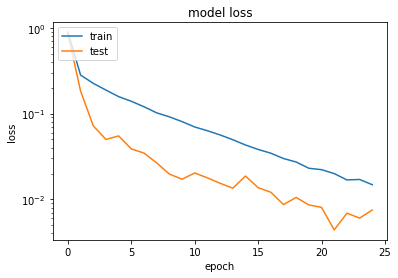

In [10]:
# summarize history for loss
plt.plot(detector_model.history.history['loss'])
plt.plot(detector_model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.yscale("log")
plt.show()

In [11]:
detector_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 2048)              128452608 
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              209817

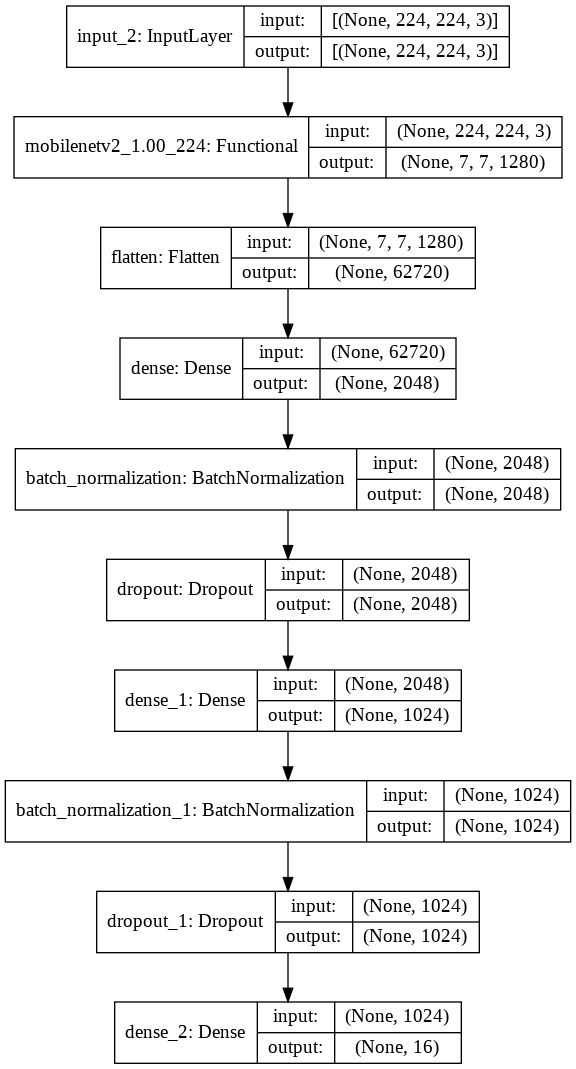

In [12]:
tf.keras.utils.plot_model(detector_model, show_shapes=True)

tf.Tensor(
[[ 36.726864 193.4663    30.85411   27.713411 197.72154   34.50304
  186.76984  187.49774   71.33432  199.68155   63.218964  29.03321
  167.52017   31.72903  165.74753  184.79503 ]], shape=(1, 16), dtype=float32)


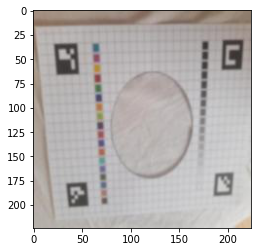

In [14]:
img = matplotlib.image.imread(validation_data["path"][0])
input = tf.convert_to_tensor([img], dtype=tf.float32) / 255.0
output = detector_model(tf.convert_to_tensor(input))
plt.imshow(img)
print(output * 224)

In [13]:
detector_model.save("./drive/My Drive/Colab Notebooks/detector_model.hdf5")  

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('./drive/My Drive/Colab Notebooks/model.tflite', 'wb') as f:
  f.write(tflite_model)